In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from xml.etree import ElementTree as ET
import random
import shutil
from collections import Counter

Annotated Text file clean

In [8]:
def is_file_not_empty(file_path):
    return os.path.isfile(file_path) and os.path.getsize(file_path) > 0

def clean_txt_yolo(txt_path, img_path):
    for files in os.listdir(txt_path):
        with open(txt_path + '/' + files, 'r') as f:
            filtered_lines = filter(lambda line: "None" not in line, f)
            filtered_lines = list(filtered_lines)

        with open(txt_path + '/' + files, 'w') as f:
            f.writelines(filtered_lines)

        if is_file_not_empty(txt_path + '/' + files):
            pass
        else:
            img_file = img_path + '/' + files.split('.')[0] + '.jpg'
            txt_file = txt_path + '/' + files
            os.remove(img_file)
            os.remove(txt_file)
            print('{} is empty'.format(files))

train_clean = clean_txt_yolo(txt_path='merged_data/validation/labels', 
                            img_path ='merged_data/validation/images')

### Image resizing

In [10]:
def img_resize(source, dest):
    img = cv2.imread(source)

    if img.shape[:-1] >= (640,640):
        dim = (640, 640)
        resized = cv2.resize(img, dim)
        cv2.imwrite(dest, resized)
    else:
        cv2.imwrite(dest, img)

source_path = 'data/train/images'
dest_path = 'data/train/resized_img'

for files in os.listdir(source_path):
    img_path = source_path + '/' + files
    img_resize(img_path, dest_path+'/'+files)

Checking the image shape.

In [7]:
img_shape = []
for files in os.listdir(dest_path):
    img = cv2.imread(dest_path+'/'+files)
    if img.shape[:-1] == (640,640):
        pass
    else:
        img_shape.append(img.shape[:-1])

for value, count in Counter(img_shape).items():
    print('{} shape of image: {}'.format(value, count))

# print('No different shape images found!')

(600, 600) shape of image: 4568
(540, 540) shape of image: 111


### Label Config

Label config

In [11]:
def label_config(annotation_file, old_img_source, dest_path):
    with open(annotation_file, 'r') as f:
        annotations = f.readlines()
        for annotation in annotations:
            x,y,w,h = annotation.strip().split(" ")[1:]

            old_img_path = old_img_source + '/' + annotation_file.split('/')[-1].split('.')[0] + '.jpg'
            old_img = cv2.imread(old_img_path)
            if old_img.shape[:-1] >= (640,640):
                new_x = (eval(x) * 640) / old_img.shape[1] # new_x = (old_x * new_width) / old_width
                new_y = (eval(y) * 640) / old_img.shape[0] # new_y = (old_y * new_height) / old_height
                new_w = (eval(w) * 640) / old_img.shape[1] # new_w = (old_w * new_width) / old_width
                new_h = (eval(h) * 640) / old_img.shape[0] # new_h = (old_h * new_height) / old_height
                
                with open(dest_path+'/'+annotation_file.split('/')[-1], 'a') as f:
                    f.write('{} {:.3f} {:.3f} {:.3f} {:.3f}\n'.format(annotation[0], new_x, new_y, new_w, new_h))
            else:
                with open(dest_path+'/'+annotation_file.split('/')[-1], 'a') as f:
                    f.write('{} {} {} {} {}\n'.format(annotation[0], x, y, w, h))

annotation_file = 'data/train/labels'
old_img_source = 'data/train/images'
dest_path = 'data/train/resized_labl'

i = 0
for files in os.listdir(annotation_file):
    label = annotation_file + '/' + files
    label_config(label, old_img_source, dest_path)
    i += 1

print(i)

10103


### Data split into train and validation

In [3]:
img = 'data/train/images'
label = 'data/train/labels'

india_count = 0
norway_count = 0
us_count = 0
japan_count = 0

for files in os.listdir(img):
    if files.startswith('Norway'):
        norway_count += 1
    if files.startswith('United_States'):
        us_count += 1
    if files.startswith('Japan'):
        japan_count += 1

print("Norway\nTrain Image: {}\tValidation image: {}".format(norway_count, int(norway_count - norway_count*0.80)))
print("United States\nTrain Image: {}\tValidation image: {}".format(us_count, int(us_count - us_count*0.80)))
print("Japan\nTrain Image: {}\tValidation image: {}".format(japan_count, int(japan_count - japan_count*0.80)))

Norway
Train Image: 2571	Validation image: 514
United States
Train Image: 2818	Validation image: 563
Japan
Train Image: 4714	Validation image: 942


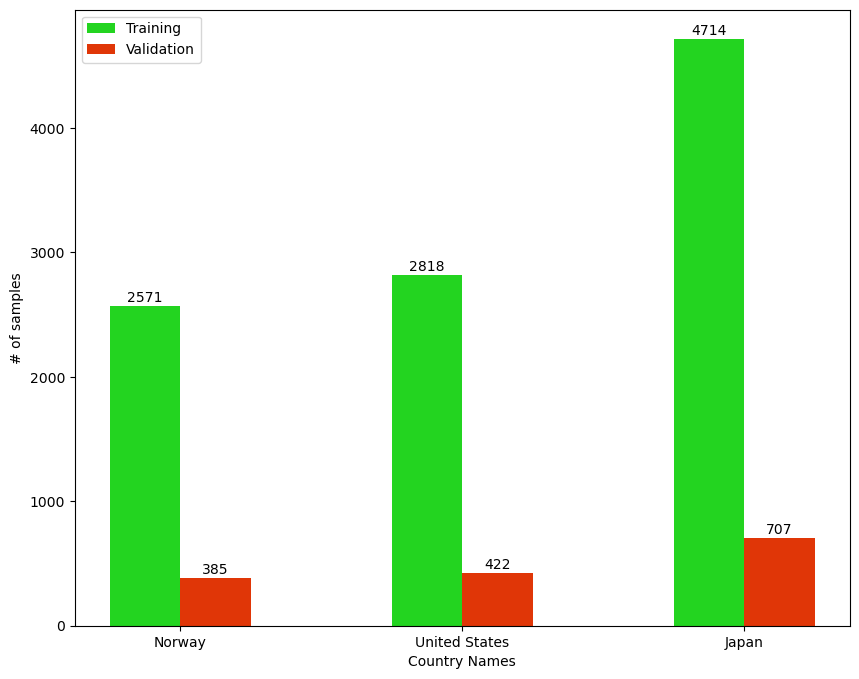

In [4]:
name = ('Norway', 'United States', 'Japan')
train_value = (norway_count,us_count,japan_count)
val_value = (int(norway_count - norway_count*0.85), int(us_count - us_count*0.85), int(japan_count - japan_count*0.85))
data = {'Training': train_value,
        'Validation': val_value}

x = np.arange(len(name))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

colors = ['#23d420', '#e03607']

fig, ax = plt.subplots(figsize= (10,8))
for attribute, measurement in data.items():
    offset = width * multiplier
    rect = ax.bar(x + offset, measurement, width, label=attribute, color=colors[multiplier]) 
    ax.bar_label(rect, padding=1)
    multiplier += 1

plt.xlabel('Country Names')
plt.ylabel('# of samples')
ax.set_xticks(x + width / 2) # added width/2 to set the ticks at the center of the bars
ax.set_xticklabels(name) # added the labels
# plt.title('Number of validation samples after Splitting.\nSplitting Ratio is 80:20')
plt.legend() # added a legend
plt.show()


Split the dataset into 80:20 ratio

In [5]:
src_img = 'data/train/images'
dest_img = 'data/validation/images'

src_label = 'data/train/labels'
dest_label = 'data/validation/labels'

jap = int(japan_count * 0.20)
nor = int(norway_count * 0.20)
us = int(us_count * 0.20)

files = os.listdir(src_img)


# Move the Japan files to validation
selected_files = random.sample([f for f in files if f.startswith('Japan')], jap)
for f in selected_files:
    img_file = os.path.join(src_img, f)
    label_file = os.path.join(src_label, f.replace('.jpg', '.txt'))
    shutil.move(img_file, dest_img)
    shutil.move(label_file, dest_label)


# Move the Norway files to validation
selected_files = random.sample([f for f in files if f.startswith('Norway')], nor)
for file in selected_files:
    img_file = os.path.join(src_img, file)
    label_file = os.path.join(src_label, file.replace('.jpg', '.txt'))
    shutil.move(img_file, dest_img)
    shutil.move(label_file, dest_label)


# Move the United States files to validation
selected_files = random.sample([f for f in files if f.startswith('United_States')], us)
for file in selected_files:
    img_file = os.path.join(src_img, file)
    label_file = os.path.join(src_label, file.replace('.jpg', '.txt'))
    shutil.move(img_file, dest_img)
    shutil.move(label_file, dest_label)